<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We're going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you'll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h4><font color=brown>Setup</font></h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

<h4><font color=brown>Reading the dataset from the system</font></h4>

In [232]:
df_ap_np = pd.read_csv('data/air_pollution.csv')
df_ap = pd.read_csv("data/air_pollution.csv", parse_dates=["date"])
df_ap_day = df_ap.groupby(pd.Grouper(freq='D', key='date')).mean()


<h4><font color=brown>Getting the basic information about the dataset</font></h4>

In [3]:
df_ap.info()
df_ap.describe()
#Zilch NaNs 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76824 entries, 0 to 76823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    76824 non-null  datetime64[ns]
 1   PC4     76824 non-null  int64         
 2   pm10    76824 non-null  float64       
 3   pm2.5   76824 non-null  float64       
 4   no2     76824 non-null  float64       
 5   no      76824 non-null  float64       
 6   so2     76824 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.1 MB


,PC4,pm10,pm2.5,no2,no,so2
count,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000
mean,5633.818182,19.300461,19.306449,25.810896,14.578421,3.419556
std,15.168756,12.790363,19.325968,13.715641,12.749047,3.060791
min,5611.000000,0.491714,0.419603,1.665652,0.000398,0.000000
25%,5622.000000,9.789488,5.986320,14.671372,4.785573,1.330161
50%,5631.000000,16.246310,12.186803,23.211536,12.002913,2.583675
75%,5646.000000,26.378854,26.603072,35.263642,22.173757,4.383727
max,5658.000000,89.593300,144.709400,79.853535,145.954814,26.323172


<h4><font color=brown>Testing for Normality</font></h4>

PC4      0.133642
pm10     1.312018
pm2.5    2.101590
no2      0.621710
no       1.845079
so2      2.078176
dtype: float64


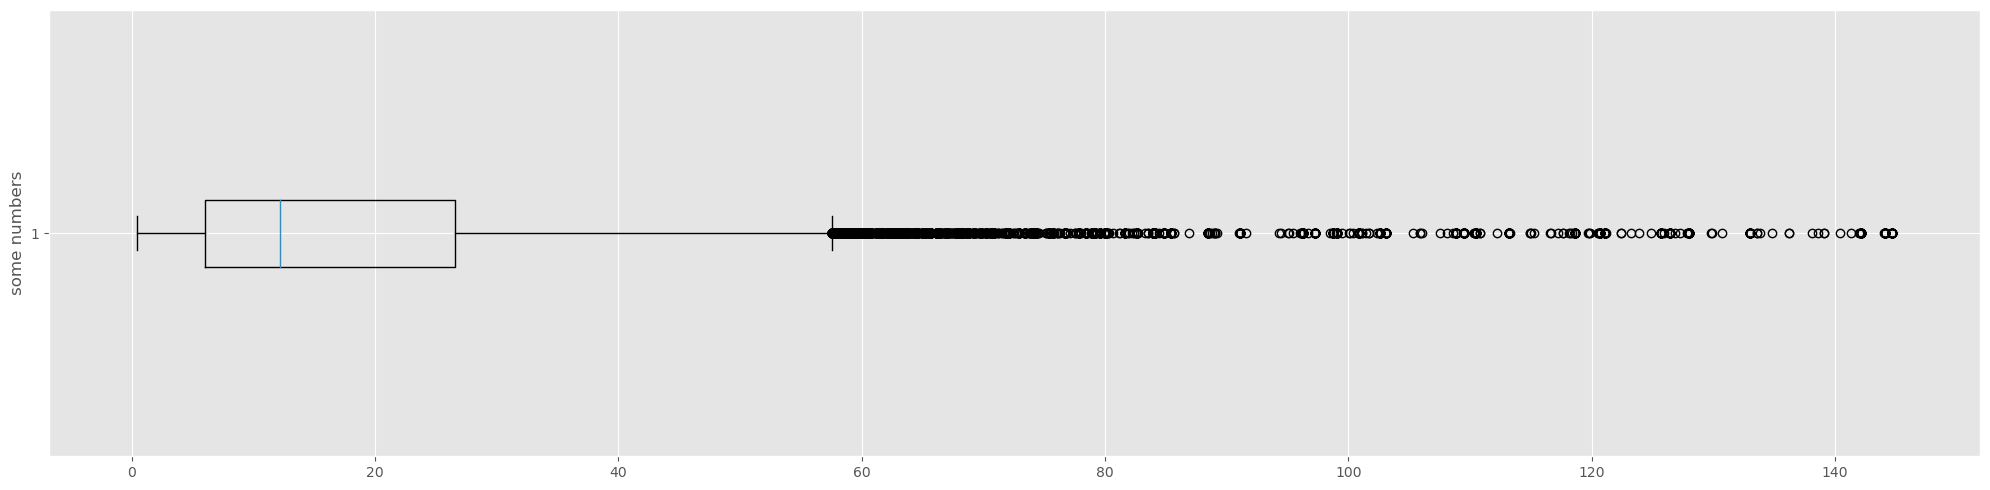

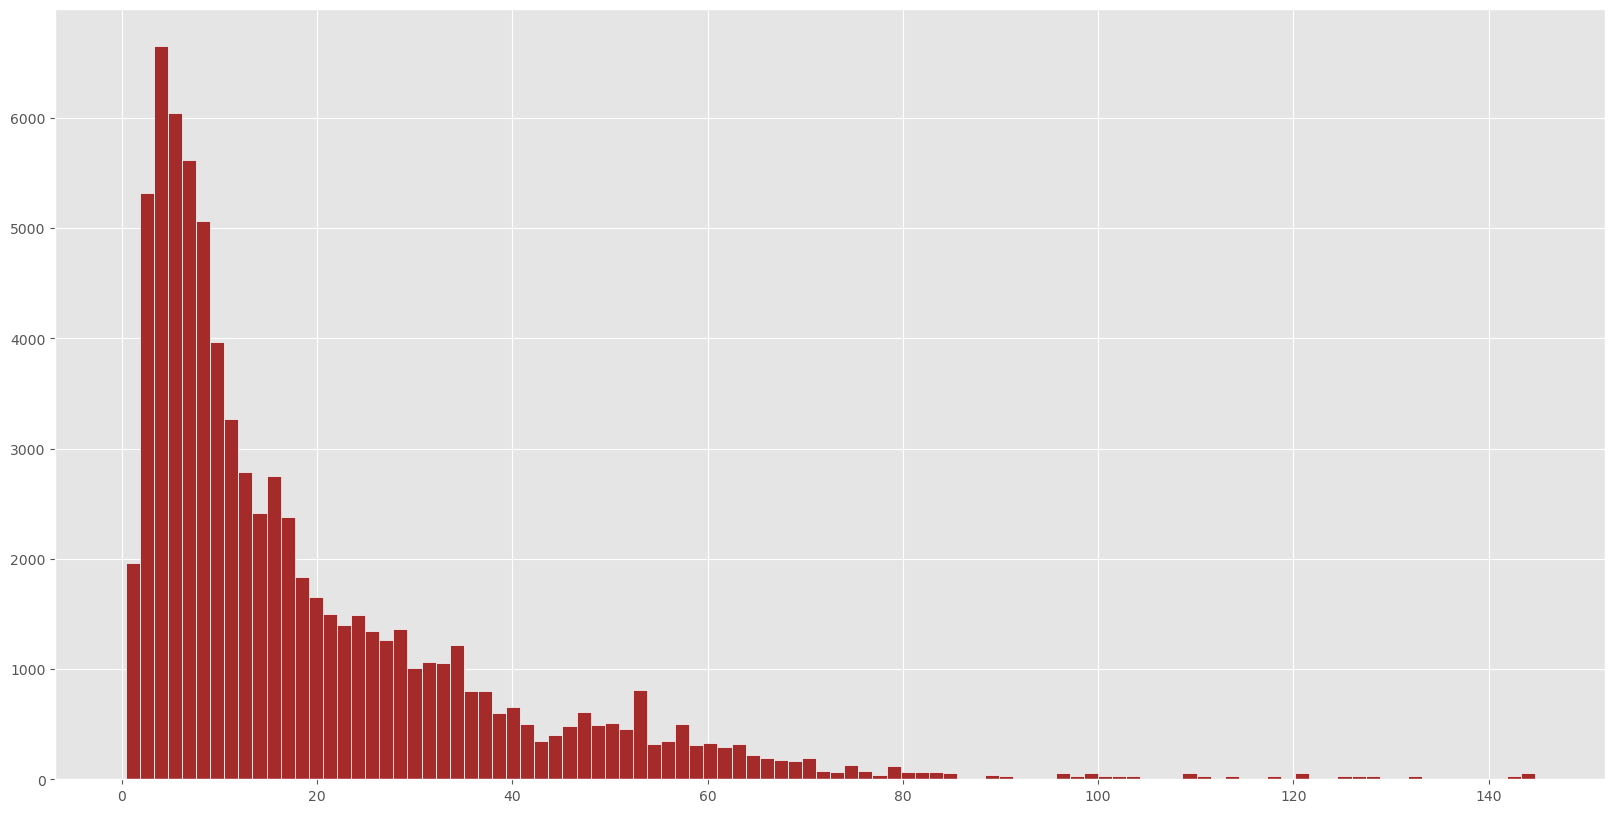

In [31]:
#Checking skewness of the dataset
print(df_ap.skew(numeric_only=True))
#Most skewed data in the dataset is the PM2.5 data
plt.figure(figsize=(20,5))
plt.boxplot( df_ap['pm2.5'], vert=False)
plt.ylabel('some numbers')
plt.tight_layout()
plt.show()
plt.figure(figsize=(20,10))
plt.hist(df_ap['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.show()
#The distribution of the PM2.5 data has a short head and a long tail
#The tail seems to be peaking, possible anomalies

<h4><font color=brown>Correlations in the dataset</font></h4>

            PC4      pm10     pm2.5       no2        no       so2
PC4    1.000000 -0.022215 -0.015463 -0.032789 -0.024208 -0.000279
pm10  -0.022215  1.000000  0.842424  0.443763  0.419273  0.354938
pm2.5 -0.015463  0.842424  1.000000  0.252095  0.178604  0.162552
no2   -0.032789  0.443763  0.252095  1.000000  0.674611  0.362617
no    -0.024208  0.419273  0.178604  0.674611  1.000000  0.309740
so2   -0.000279  0.354938  0.162552  0.362617  0.309740  1.000000


Pearson: 0.8424240709438268
Spearman: 0.8868444860412877


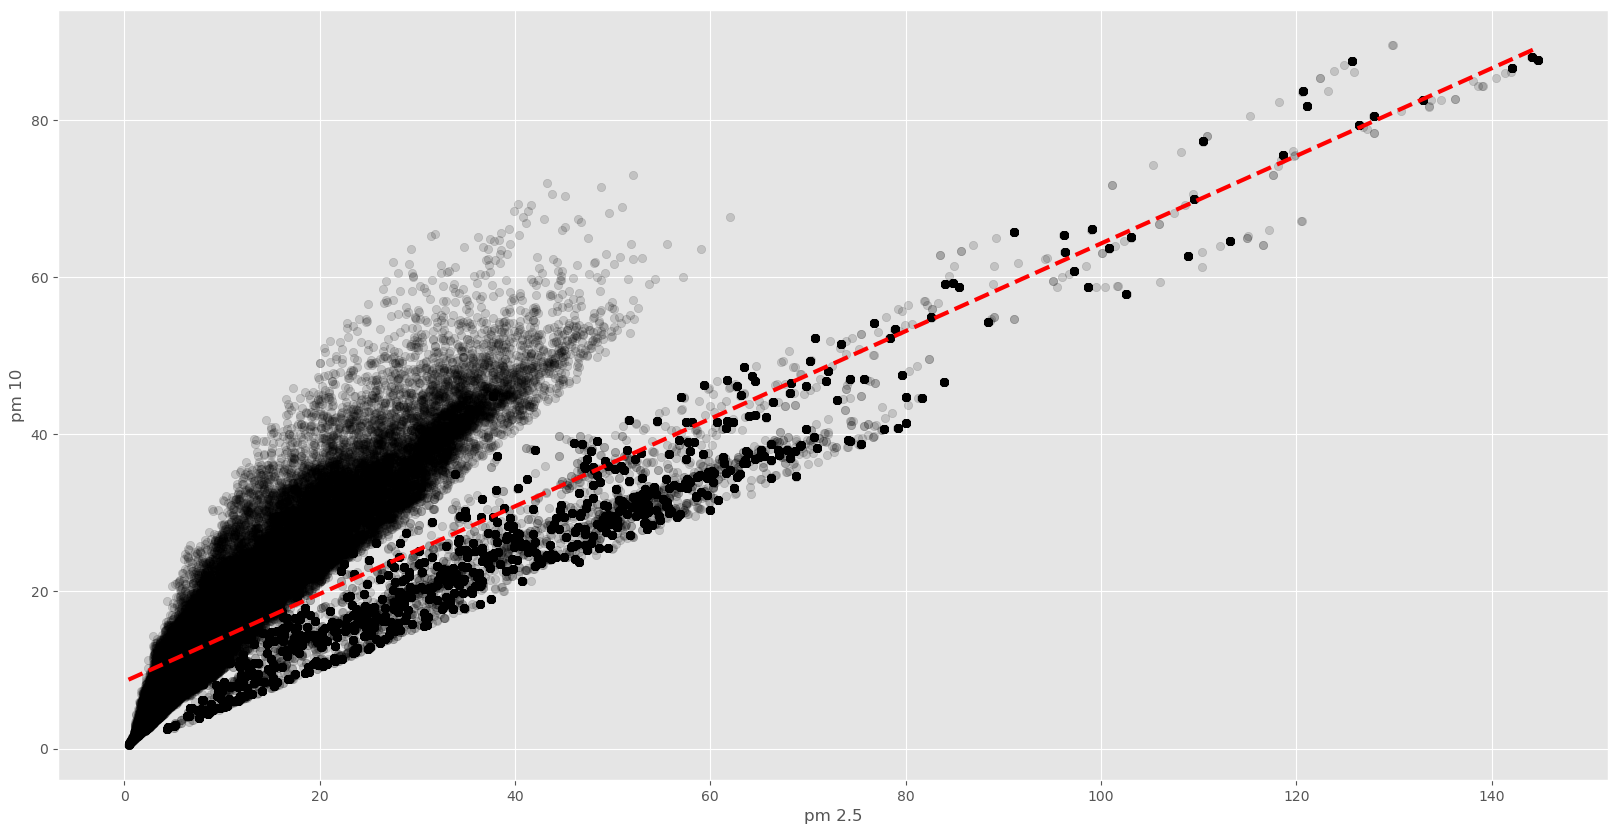

In [226]:
#Correlation matrix
print(df_ap.corr(numeric_only=True))
print('\n')
print('Pearson: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='pearson')))
print('Spearman: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='spearman')))

#The highest correlation in the dataset is between PM10 and PM2.5 data 
plt.figure(figsize=(20,10))
plt.scatter(df_ap["pm2.5"], df_ap["pm10"], alpha=.15, color='black')
plt.plot(np.unique(df_ap["pm2.5"]), np.poly1d(np.polyfit(df_ap["pm2.5"], df_ap["pm10"], 1))
         (np.unique(df_ap["pm2.5"])), color='red', linewidth=3, linestyle='dashed')
plt.xlabel('pm 2.5')
plt.ylabel('pm 10')
plt.show()

<h4><font color=brown>Average PM2.5 per day</font></h4>

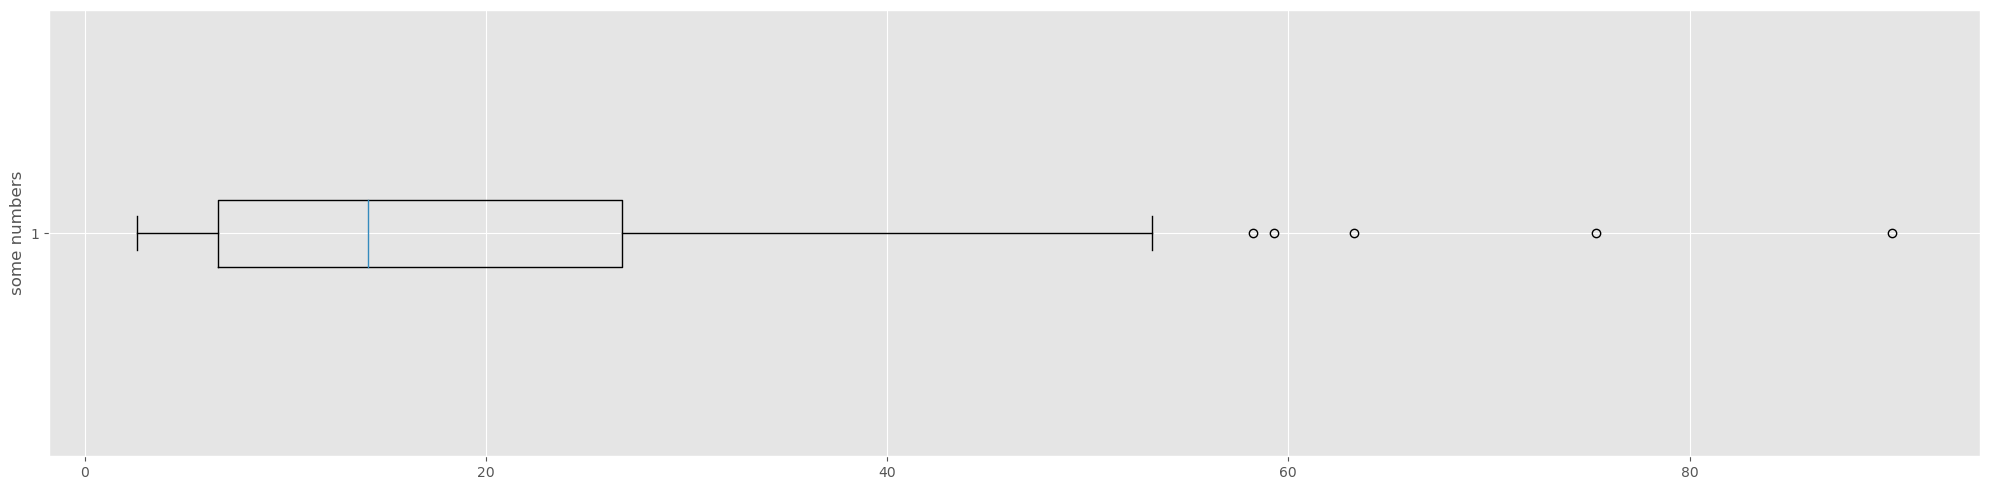

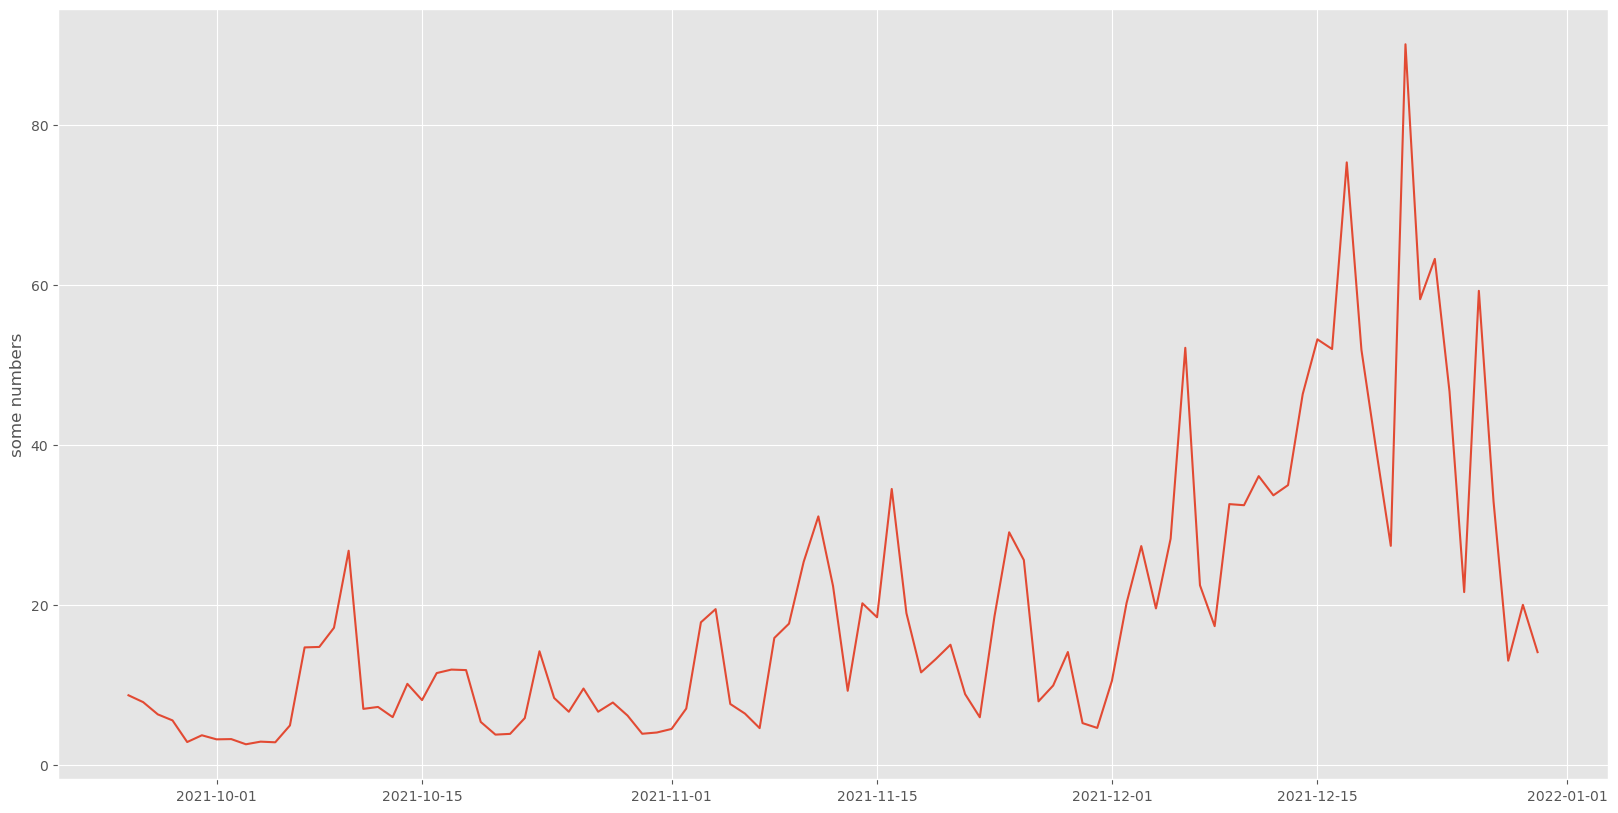

In [11]:
plt.figure(figsize=(20,5))
plt.boxplot( group_by_day['pm2.5'], vert=False)
plt.ylabel('some numbers')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(group_by_day['pm2.5'])
plt.ylabel('some numbers')
plt.show()

<h4><font color=brown> Worst sum total pollution in different postal code areas</font></h4>

Most populted areas with the polution type:


,PC4,pm10,pm2.5,no2,no,so2
0,5611,46522.935662,46467.514003,61860.833442,35124.505697,8125.203148
1,5612,46474.338873,46290.355122,61981.770058,35203.629187,8090.599943
2,5613,45329.607789,45606.074870,60622.571647,34314.366390,7963.147716
3,5614,44988.091305,45347.120054,59802.954923,33778.127737,7926.098401
4,5615,45904.200338,45920.352212,60425.878260,34185.678608,8068.407175
5,5616,46704.512015,46560.068434,61077.354240,34611.910237,8164.492344
6,5617,47003.201839,46707.069901,61399.647628,34822.772357,8157.659619
7,5621,46176.732648,46222.198577,60785.768669,34421.138888,7990.763175
8,5622,46246.898787,46166.111948,61200.980875,34692.793730,7985.110486
9,5623,46733.047492,46504.087210,62146.867281,35311.644924,8038.836355


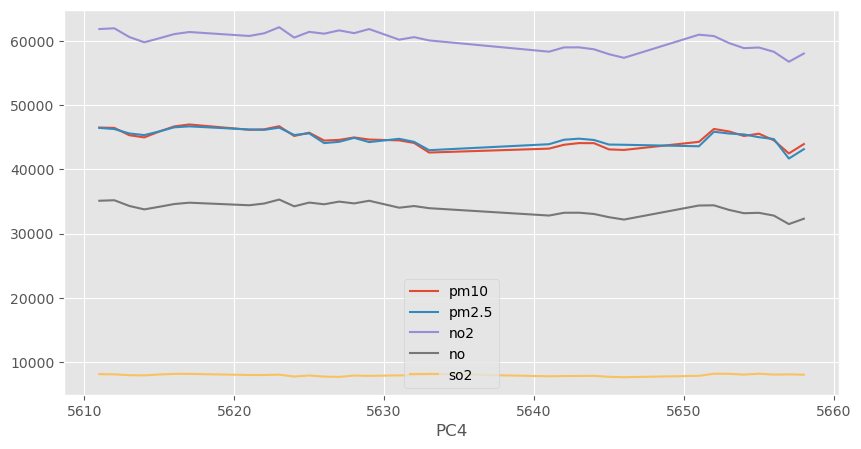

In [229]:
df_ap_sp = df_ap.groupby(['PC4']).sum(numeric_only=True)
df_ap_sp.plot(legend=True, figsize=(10,5))

print('Most populted areas with the polution type:')
df_ap_sp = df_ap_sp.drop_duplicates()
df_ap_sp.reset_index().style.highlight_max(color = 'orange')

<h4><font color=brown> Wost peak pollution in different postal code areas</font></h4>

Max polution in different areas with the polution type:


,PC4,pm10,pm2.5,no2,no,so2
0,5611,88.080540,144.709400,71.381888,121.946628,23.344864
1,5612,88.080540,144.709400,71.274923,121.946628,25.220871
2,5613,88.080530,144.709400,69.206424,121.946628,23.386072
3,5614,88.080530,144.709400,68.357741,121.946628,20.949102
4,5615,88.080530,144.709400,71.718876,121.946628,21.319842
5,5616,88.080530,144.709400,75.743100,121.946628,24.085637
6,5617,88.080540,144.709400,76.095894,121.946628,25.071658
7,5621,88.080540,144.709400,73.775033,121.946628,26.241260
8,5622,88.080540,144.709400,72.820876,121.946628,26.130241
9,5623,88.080530,144.709400,71.342982,121.946628,26.261284


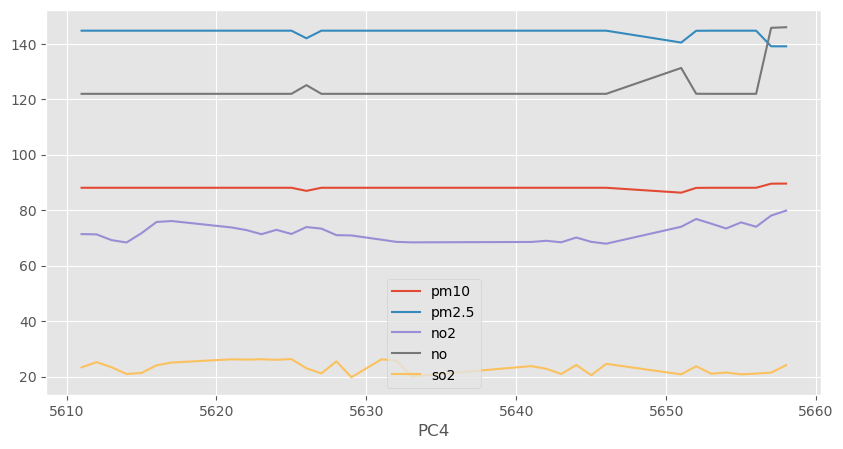

In [220]:
df_ap_mp = df_ap.groupby(['PC4']).max(numeric_only=True)
df_ap_mp.plot(legend=True, figsize=(10,5))

print('Max polution in different areas with the polution type:')
df_ap_mp = df_ap_mp.drop_duplicates()
df_ap_mp.reset_index().style.highlight_max(color = 'orange')

#The PM2.5 sensor is peaking in different areas 

<h4><font color=brown> Least pollution in different postal code areas</font></h4>

Least polution in different areas with the polution type:


,PC4,pm10,pm2.5,no2,no,so2
0,5611,0.530789,0.451635,2.392360,0.000398,0.000000
1,5612,0.578179,0.473515,2.544250,0.000398,0.000000
2,5613,0.520031,0.439185,2.219685,0.000398,0.000000
3,5614,0.498157,0.427967,1.988143,0.000398,0.000000
4,5615,0.501704,0.430377,2.091708,0.000398,0.000000
5,5616,0.700163,0.534429,2.404782,0.000398,0.000000
6,5617,0.814963,0.579557,2.532816,0.000398,0.000000
7,5621,0.876251,0.615081,2.593142,0.000398,0.000000
8,5622,0.777373,0.573218,2.641720,0.000398,0.000000
9,5623,0.626090,0.506606,2.755169,0.000398,0.000000


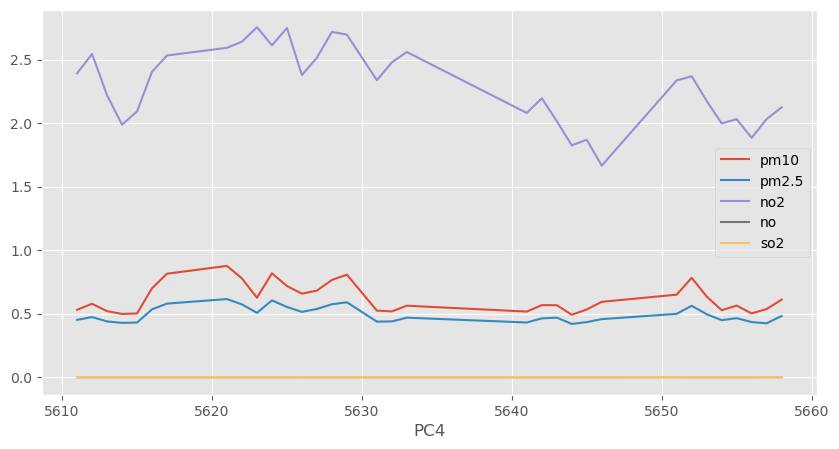

In [228]:
df_ap_lp = df_ap.groupby(['PC4']).min(numeric_only=True)
df_ap_lp.plot(legend=True, figsize=(10,5))

print('Least polution in different areas with the polution type:')
df_ap_lp = df_ap_lp.drop_duplicates()
df_ap_lp.reset_index().style.highlight_max(color = 'lightgreen')

#The sulfur dioxide sensor is detecting nothing, sometimes

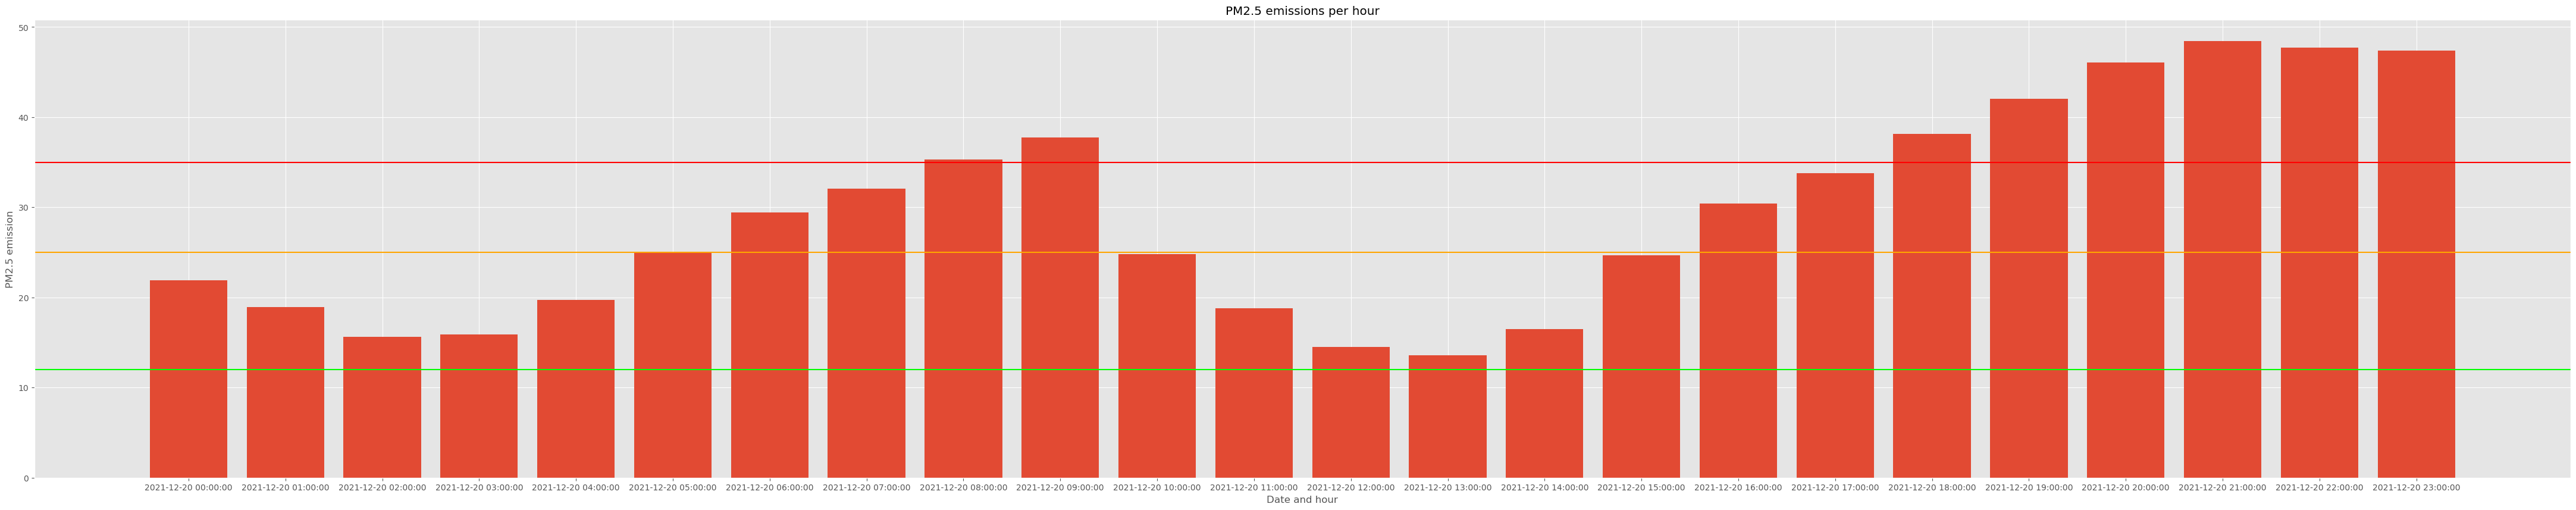

In [233]:
# DOUBLE CLICK ON THE GRAPH TO ZOOM IN #

START_DATE = '2021-12-20'
END_DATE = '2021-12-21'

FIG_HEIGHT = 10
FIG_WIDTH = 55


mask = (df_ap_np['date'] > START_DATE) & (df_ap_np['date'] <= END_DATE)
air_pollution = df_ap_np.loc[mask]

x_axis = list(air_pollution.loc[:,'date'])
y_axis = list(air_pollution.loc[:,'pm2.5'])

f = plt.figure()
f.set_figheight(FIG_HEIGHT)
f.set_figwidth(FIG_WIDTH)
plt.bar(x_axis, y_axis)
plt.title("PM2.5 emissions per hour")
plt.xlabel("Date and hour")
plt.ylabel("PM2.5 emission")

healthy_level = [12]
legal_limit = [25]
unhealthy_level = [35]

plt.axhline(y = healthy_level, color = '#00FF00', linestyle = '-')
plt.axhline(y = legal_limit, color = '#FFA500', linestyle = '-')
plt.axhline(y = unhealthy_level, color = '#FF0000', linestyle = '-')

plt.show()

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>